In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
# path = '2019-11-22_19-07-57_その1.txt'
path = '2019-11-22_19-15-11_その2.txt'

In [3]:
# A1が筋電位、A2が心電図、A3が皮膚電気活動
columns = ["nSeq", "I1", "I2", "O1", "O2", "A1", "A2", "A3", "A4", "A5", "A6"]
sampling_rate = 1000

df = None
reader = pd.read_csv(path, sep='\t', header=None, names=columns, index_col=False, chunksize=600*sampling_rate)
for r in reader:
    if df is None:
        #  頭から3行目は要らない
        df = r.drop([i for i in range(3)])
    else:
        df = df.append(r, ignore_index=True)
        
df = df.reset_index(drop=True)

print(df.shape)
df.head()

(485250, 11)


/Users/kessapassa/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,nSeq,I1,I2,O1,O2,A1,A2,A3,A4,A5,A6
0,0,0.0,0.0,0.0,0.0,510.0,497.0,102.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,509.0,499.0,102.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,509.0,499.0,102.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,506.0,500.0,102.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,505.0,501.0,102.0,0.0,0.0,0.0


In [4]:
target='A2'
df_target = df[target][10500:11500]

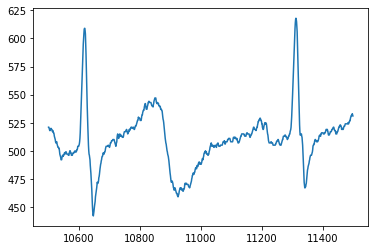

In [5]:
plt.plot(df_target)

# 加法モデル

In [6]:
ts = sm.tsa.seasonal_decompose(df_target.values, freq=12)

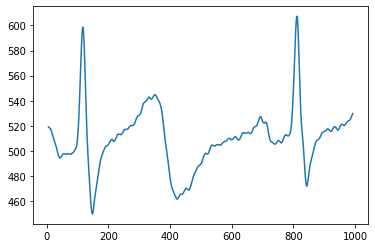

In [7]:
# トレンド
plt.plot(ts.trend)

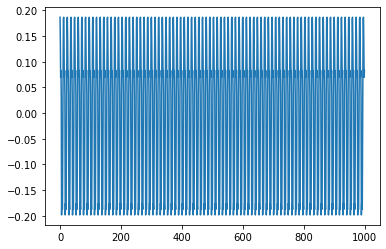

In [8]:
# 季節変動
plt.plot(ts.seasonal)

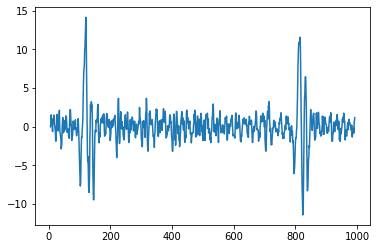

In [9]:
# 不規則変動
plt.plot(ts.resid)

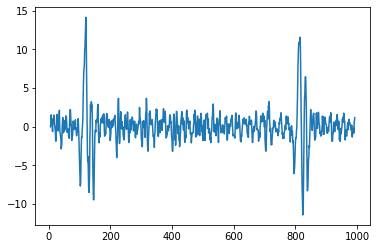

In [10]:
restoration = ts.trend + ts.seasonal
res = df_target.values.flatten()[6:-6] - restoration.flatten()[6:-6]

# 傾向変動+季節変動と観測データとの差分
plt.plot([np.float('nan')]*6 + res.tolist() + [np.float('nan')]*6)

# 乗法モデル

In [11]:
ts_mult = sm.tsa.seasonal_decompose(df_target.values, freq=12,  model='multiplicative')

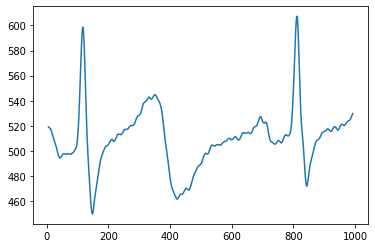

In [12]:
# トレンド
plt.plot(ts_mult.trend)

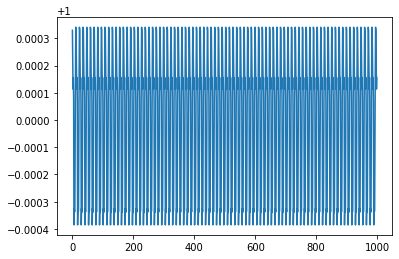

In [13]:
# 季節変動
plt.plot(ts_mult.seasonal)

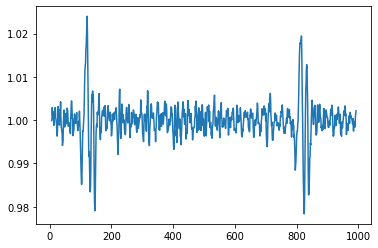

In [14]:
# 不規則変動（原系列/(トレンド*季節変動)）
plt.plot(ts_mult.resid)

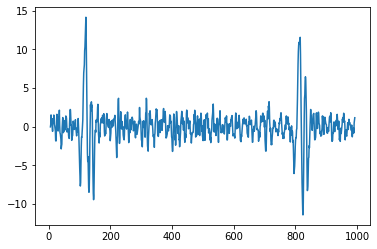

In [15]:
restoration_mult = ts_mult.trend * ts_mult.seasonal
res_mult = df_target.values.flatten()[6:-6] - restoration_mult.flatten()[6:-6]

# 傾向変動*季節変動と観測データとの差分
plt.plot([np.float('nan')]*6 + res_mult.tolist() + [np.float('nan')]*6)

# 移動平均
不規則に上下する誤差変動(ノイズ)を時系列変動の平滑化(スムージング)をしてノイズをキャンセルアウトする

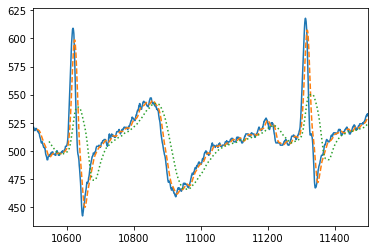

In [16]:
plt.plot(df_target)
df_target.rolling(window=12).mean().plot(style='--')
df_target.rolling(48).mean().plot(style=':')

# 中心化移動平均
変動周期に合わせたウィンドウサイズを用いた移動平均を取り、原系列データから季節変動パターンを取り除く

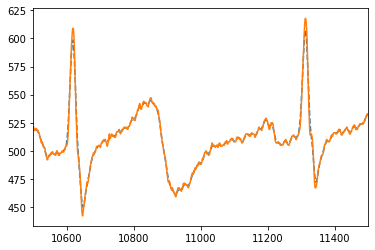

In [17]:
# 移動平均
df_ma = df_target.rolling(window=12).mean().shift(-6)

# 中心化移動平均
df_cma = df_ma.rolling(window=2).mean()

# 中心化移動平均系列
df_cma.plot(style='--', label='CMA')
# 原系列
df_target.plot(label='observation')

# 季節調整
簡単な季節調整の方法と季節パターンの求め方

In [18]:
# 原系列(df_ice.expenditure_yen)/中心化移動平均系列(df_cma) 
df_orig_div_cma = df_target / df_cma

# 月毎に加算
orig_div_cma = df_orig_div_cma.values
s_index = np.zeros(12)
counter = np.zeros(12, dtype='i')
for idx in range(len(orig_div_cma)//12):
    # 12ヶ月ごとにデータを抽出
    cut_orig_div_cma = orig_div_cma[idx*12:(idx+1)*12]
    mask = cut_orig_div_cma!=cut_orig_div_cma
    # numpy.whereを使用して非数(nan)を0にして加算する
    counter += np.where(mask, 0, 1)
    s_index += np.where(mask, 0, cut_orig_div_cma)

# 加算結果の各月平均
s_index /= counter
# 全体を1200に合わせ季節指数を計算
s_index = s_index / s_index.sum() * 1200
s_index

array([100.03300732, 100.02332021, 100.01139354, 100.01562385,
       100.00754043,  99.96145321,  99.96747896,  99.96613963,
        99.96680632,  99.99652454, 100.01659151, 100.03412048])

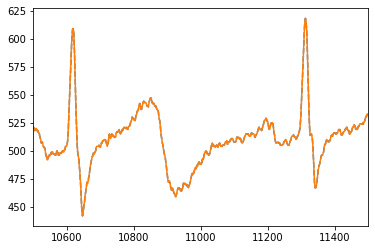

In [19]:
# 季節指数を原系列の要素と対応させる
# 原系列のスタートが1月なのでtileして12ヶ月分の季節指数を繰り返すだけで良い
tiled_s_index = np.tile(s_index, len(orig_div_cma)//12)

# 4つ分多いので最後尾を削除して調整
index = df_target.index.values
df_target_ajusted = df_target.drop([i for i in range(index[-1], index[-5], -1)])

# 季節調整済み系列の計算
df_adjusted_series = df_target_ajusted / tiled_s_index * 100

# 季節調整済み系列
df_adjusted_series.plot(style='--', label='adjusted')
# 原系列
df_target.plot(label='observation')

# 移動平均乖離率
移動平均系列と原系列データとがどの程度離れているかを示す指標

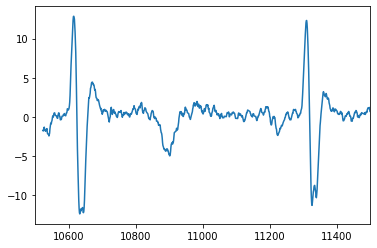

In [20]:
ma24 = df_target.rolling(24).mean()
diff_ma24 = (df_target - ma24) / ma24 * 100
diff_ma24.plot()

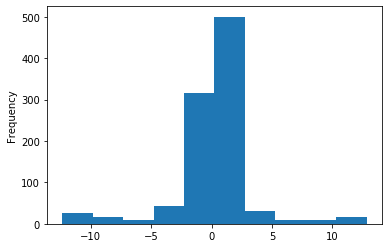

In [21]:
diff_ma24.plot.hist()

# 移動平均偏差率
シャピロ-ウィルク検定

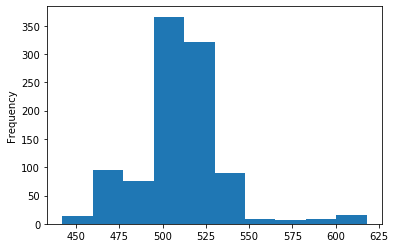

In [22]:
df_target.plot.hist()

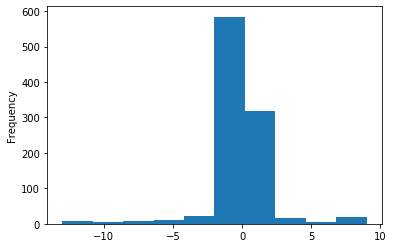

In [23]:
# 1次階差
# 階差をとることで値が欠損する行が生じるためdropna()でその行を削除する
df_diff1 = df_target.diff().dropna()
# 1次階差系列のヒストグラムの表示
df_diff1.plot.hist()

In [24]:
import scipy.stats as stats

# 1次階差系列のShapiro-Wilk検定
# (W総計量, p値)で結果が出力される
stats.shapiro(df_diff1.values)

(0.7602939009666443, 9.552409038512134e-36)

In [25]:
# 原系列のShapiro-Wilk検定
stats.shapiro(df_target.values)

(0.9119976162910461, 1.3081244940060357e-23)

# 時間依存性の発見(自己相関の検定)

In [26]:
# 自己相関
p_acf = sm.tsa.stattools.acf(df_target)

# 偏自己相関
p_pacf = sm.tsa.stattools.pacf(df_target, method='ols')
p_acf, p_pacf

/Users/kessapassa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(array([1.        , 0.99562144, 0.98436927, 0.96679784, 0.94369257,
        0.91582326, 0.88400031, 0.84895604, 0.81163047, 0.77279964,
        0.73318654, 0.69331579, 0.65358089, 0.61422388, 0.57547898,
        0.53740863, 0.50004407, 0.46338374, 0.42748072, 0.39236782,
        0.35811217, 0.32479966, 0.29255676, 0.26156305, 0.23201683,
        0.20416794, 0.17821467, 0.15433191, 0.13264927, 0.11327293,
        0.09619665, 0.08148756, 0.06908166, 0.05884309, 0.05059851,
        0.04405282, 0.03889996, 0.03491197, 0.03189679, 0.02946092,
        0.02744039]),
 array([ 1.        ,  0.99630809, -0.87233943, -0.22267213,  0.03899136,
         0.09249777,  0.05529091,  0.03042694,  0.10028411,  0.0406351 ,
        -0.03232438, -0.01191544, -0.08984184, -0.07216292, -0.02417471,
        -0.02333094, -0.02277877,  0.00734058,  0.01844211,  0.037883  ,
         0.01137962,  0.02798571,  0.01875401,  0.02636605,  0.01232531,
         0.05399214,  0.01172885, -0.01733253, -0.01782886,  0.017293

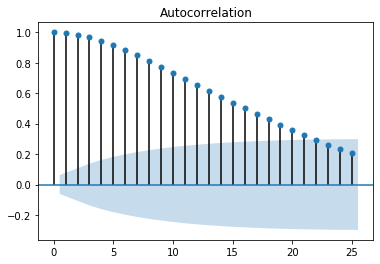

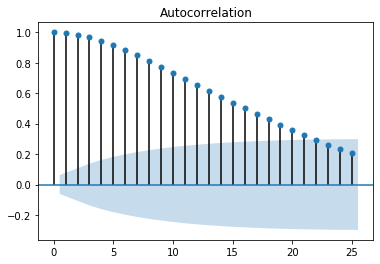

In [27]:
sm.graphics.tsa.plot_acf(df_target, lags=25)

/Users/kessapassa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


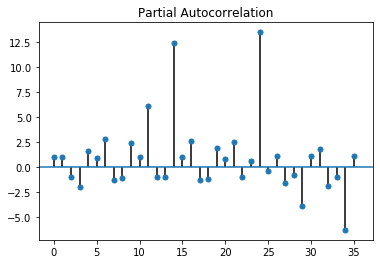

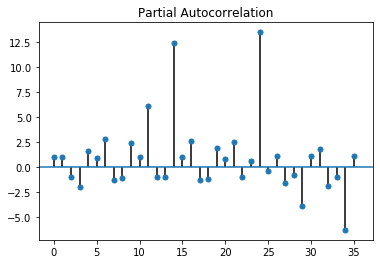

In [28]:
sm.graphics.tsa.plot_pacf(df_target, lags=35)

# 定常性(時系列データの性質)
時間性依存を考慮して分析するため、時系列データが同一の分布に従うという条件を元に時系列データ分析に適した前提条件を考える
弱定常性を満たす時自己相関も時点に依存しなくなる
強定常性は当該性質は同時分布が不変であることを要求している。つまり各時点の確率分布が等しいことが条件となっている

In [29]:
# pct_changeで移動率を計算する。また機能はdf_target.div(df_target.shift(1)) - 1と同じである
df_logdiff = (1 + df_target.pct_change()).apply(np.log)

print(df_logdiff)
print(df_target.div(df_target.shift(1)) - 1)

10500         NaN
10501    0.000000
10502   -0.001921
10503   -0.001925
10504   -0.001929
           ...   
11495    0.001881
11496    0.000000
11497    0.001878
11498   -0.001878
11499   -0.001881
Name: A2, Length: 1000, dtype: float64
10500         NaN
10501    0.000000
10502   -0.001919
10503   -0.001923
10504   -0.001927
           ...   
11495    0.001883
11496    0.000000
11497    0.001880
11498   -0.001876
11499   -0.001880
Name: A2, Length: 1000, dtype: float64


In [30]:
(1 + (df_target.div(df_target.shift(1)) - 1)).apply(np.log)

10500         NaN
10501    0.000000
10502   -0.001921
10503   -0.001925
10504   -0.001929
           ...   
11495    0.001881
11496    0.000000
11497    0.001878
11498   -0.001878
11499   -0.001881
Name: A2, Length: 1000, dtype: float64

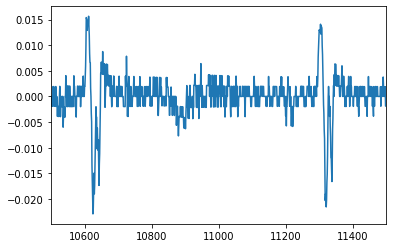

In [31]:
df_logdiff.plot()